# Experiment  0: ToM Overall Model Performance


In [32]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch

In [33]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [34]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [35]:
def visualize_map(campus,
                  path=None,
                  goal_nodes=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if goal_nodes:
        goal_coords = [campus.node_coords[n] for n in goal_nodes]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Goal")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

In [36]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color


## Steps  
1. Create the UCSD campus world
2. Create n agents each with a specific distribution over the goals
3. Run m epsiodes where each agent chooses a goal and performs a single path to that goal
4. Use this data as training set

## Step 1: Create the Map

In [37]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Started new simulation run #11
All visualizations will be saved to: /Users/arshia/UCSD/Theory-of-mind/notebooks/visuals/run_11_20250709_161910
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3136 nodes and 8704 edges


## Step 2: Create N Agents

In [38]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [39]:
""" Already created agents and saved as pkl
# Create n agents
agents = []
n = 100
for i in range(n):
    agents.append(AgentFactory.create_agent("shortest"))
    agents[i].id = i

n_goals = len(goals)
ag_alpha = np.random.normal(1, 0.2, size=n_goals)

for agent in agents: # Set each agent's goal distribution
    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]
    agent.environment = campus

# Save the agents 
import pickle

# suppose `agents` is your list of Agent instances
with open('agents.pkl', 'wb') as f:
    pickle.dump(agents, f)

"""

' Already created agents and saved as pkl\n# Create n agents\nagents = []\nn = 100\nfor i in range(n):\n    agents.append(AgentFactory.create_agent("shortest"))\n    agents[i].id = i\n\nn_goals = len(goals)\nag_alpha = np.random.normal(1, 0.2, size=n_goals)\n\nfor agent in agents: # Set each agent\'s goal distribution\n    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]\n    agent.environment = campus\n\n# Save the agents \nimport pickle\n\n# suppose `agents` is your list of Agent instances\nwith open(\'agents.pkl\', \'wb\') as f:\n    pickle.dump(agents, f)\n\n'

In [40]:
def new_episode(agents):

    # Set the goal and start nodes
    for agent in agents:
        agent.path = [] # Clear the old path
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])

        while True:
            start_node = campus.get_random_node()
            try:
                path = nx.shortest_path(campus.G_undirected, 
                                       source=start_node, 
                                       target=agent.goal_node, 
                                       weight='length')
                if len(path) >15:  # Make sure path is non-trivial
                    break
            except:
                continue
        agent.start_node = start_node
        agent.current_node = start_node

    return 

## Step 3: Perform Episodes and Data Collection

In [41]:
import json

In [11]:
""" Already ran once. Data is saved in /data

path_data = {}
goal_data = {}
m = 100
for episode in range(m):
    new_episode(agents)
    episode_path_data = {}
    episode_goal_data = {}
    for agent in agents:
        agent.plan_path()
        episode_path_data[agent.id] = agent.path
        episode_goal_data[agent.id] = agent.goal_node
    # Save the data from each episode
    path_data[episode] = episode_path_data
    goal_data[episode] = episode_goal_data

with open("./data/path_data.json", "w") as file:
    json.dump(path_data, file, indent=4)

with open("./data/goal_data.json", "w") as file:
    json.dump(goal_data, file, indent=4)

"""

' Already ran once. Data is saved in /data\n\npath_data = {}\ngoal_data = {}\nm = 100\nfor episode in range(m):\n    new_episode(agents)\n    episode_path_data = {}\n    episode_goal_data = {}\n    for agent in agents:\n        agent.plan_path()\n        episode_path_data[agent.id] = agent.path\n        episode_goal_data[agent.id] = agent.goal_node\n    # Save the data from each episode\n    path_data[episode] = episode_path_data\n    goal_data[episode] = episode_goal_data\n\nwith open("./data/path_data.json", "w") as file:\n    json.dump(path_data, file, indent=4)\n\nwith open("./data/goal_data.json", "w") as file:\n    json.dump(goal_data, file, indent=4)\n\n'

### Load existing data

In [9]:
import json, pickle

with open("./data/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/goal_data.json", 'r') as file:
    goal_data = json.load(file)

with open('agents.pkl', 'rb') as f:
    agents = pickle.load(f)

In [10]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [11]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 4: Fit the Models
There should again be a dict of dict for posteriors. The first key will be for the episode, the second key will be the agent, and the value of this will be a list of dicts for the posteriors. 

### BToM

In [11]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [12]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done


In [13]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

for episode in range(len(goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, path_data[episode][agent.id])
    # Reset the posteriors for new episode
    btom.reset_posteriors()

### Extended BToM

In [12]:
# Import BToM baseline
from real_world_src.models.extended_btom import Extended_BToM

In [13]:
ext_btom = Extended_BToM(campus, agents, goals)

Computing shortest paths...
Done


In [14]:
# Calculate all the posteriors using the first 30 episode
ext_posteriors_data = {}

for episode in range(len(goal_data)):
    ext_posteriors_data[episode] = {}
    for agent in agents:
        ext_posteriors_data[episode][agent.id] = ext_btom.update_agent_posterior_over_path(agent, path_data[episode][agent.id])



In [15]:
# Save extended BToM to load for other experiments
# suppose `agents` is your list of Agent instances
with open('extended_btom.pkl', 'wb') as f:
    pickle.dump(ext_btom, f)

# To get posterior data

In [22]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

### LSTM

In [16]:
# Import LSTM model and helpers
from real_world_src.models.lstm import (
    SimpleLSTM, LSTMDataset, lstm_collate_fn,
    train_lstm_model, evaluate_lstm_model, predict_goal_posterior
)
from torch.utils.data import DataLoader

In [17]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

In [18]:
# Prepare dataset and dataloader
# Batch size = 32
lstm_dataset = LSTMDataset(path_data, goal_data, node2idx, goal2idx)
lstm_loader = DataLoader(lstm_dataset, batch_size=32, shuffle=True, collate_fn=lstm_collate_fn) 

In [19]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [20]:
# Instantiate and train the model
lstm_model = SimpleLSTM(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)  # Learning rate =0.001
train_lstm_model(lstm_model, lstm_loader, optimizer, device, num_epochs=10)


Epoch 1/10 - Loss: 2.5207
Epoch 2/10 - Loss: 2.3384
Epoch 3/10 - Loss: 1.9473
Epoch 4/10 - Loss: 1.8668
Epoch 5/10 - Loss: 1.6814
Epoch 6/10 - Loss: 1.7214
Epoch 7/10 - Loss: 1.7138
Epoch 8/10 - Loss: 1.6346
Epoch 9/10 - Loss: 1.6576
Epoch 10/10 - Loss: 1.9906


In [21]:
# Evaluate the model
evaluate_lstm_model(lstm_model, lstm_loader, device)

Evaluation accuracy: 0.3359


0.3359

In [23]:

# Compute posteriors along paths for all agents/episodes
lstm_posteriors = {}

for episode in range(len(goal_data)):
    lstm_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        path = path_data[episode][agent.id]
        
        posteriors_along_path = []
        for t in range(1, len(path)+1):
            subpath = path[:t]
            posterior = predict_goal_posterior(lstm_model, subpath, node2idx, goal2idx, device)
            posteriors_along_path.append(posterior)
        lstm_posteriors[episode][agent.id] = posteriors_along_path

### GRU

In [24]:
from real_world_src.models.gru import (
    SimpleGRU, GRUDataset, gru_collate_fn,
    train_gru_model, evaluate_gru_model, predict_goal_posterior_gru
)
from torch.utils.data import DataLoader

In [25]:
# Prepare dataset and dataloader
gru_dataset = GRUDataset(path_data, goal_data, node2idx, goal2idx)
gru_loader = DataLoader(gru_dataset, batch_size=32, shuffle=True, collate_fn=gru_collate_fn)

In [26]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [27]:
# Instantiate and train the model
gru_model = SimpleGRU(num_nodes=len(node2idx), num_goals=len(goal2idx)).to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)
train_gru_model(gru_model, gru_loader, optimizer, device, num_epochs=10)

Epoch 1/10, Loss: 2.4979
Epoch 2/10, Loss: 0.9067
Epoch 3/10, Loss: 0.2134
Epoch 4/10, Loss: 0.0500
Epoch 5/10, Loss: 0.0289
Epoch 6/10, Loss: 0.0121
Epoch 7/10, Loss: 0.0080
Epoch 8/10, Loss: 0.0059
Epoch 9/10, Loss: 0.0041
Epoch 10/10, Loss: 0.0401


In [28]:
# Evaluate the model
evaluate_gru_model(gru_model, gru_loader, device)


Evaluation accuracy: 0.9987


0.9987

In [30]:
from tqdm import tqdm

In [31]:
# Compute posteriors along paths for all test agents/episodes
# Define test_agent_ids for GRU evaluation (use same split as ToMNet)
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

gru_posteriors = {}
for episode in tqdm(range(len(goal_data)), desc="Episode"):
    gru_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        path = path_data[episode][agent.id]
        posteriors_along_path = []
        for t in range(1, len(path)+1):
            subpath = path[:t]
            posterior = predict_goal_posterior_gru(gru_model, subpath, node2idx, goal2idx, device)
            posteriors_along_path.append(posterior)
        gru_posteriors[episode][agent.id] = posteriors_along_path

Episode: 100%|██████████| 100/100 [09:18<00:00,  5.59s/it]


### ToMNet

In [44]:
from real_world_src.models.simple_tomnet import ToMNet, ToMNetDataset, tomnet_collate_fn, infer_goal_dists
from torch.utils.data import Dataset, DataLoader


In [45]:
def get_posterior_format(dists):
    idx2goal = { idx: goal for goal, idx in goal2idx.items() }
    goal_posterior = [ {idx2goal[i]: float(p) for i, p in enumerate(prob_row) } for prob_row in dists]
    return goal_posterior

In [ ]:
device = 'mps'

# the values you trained with:
K     = 10
T_sup = 75
T_q   = 20


model = ToMNet(
    num_nodes = len(campus.nodes),
    #num_nodes=3108,
    num_goals = len(goals),
    K     = K,
    T_sup = T_sup,
    T_q   = T_q,
).to(device)

state_dict = torch.load(
    "../real_world_src/models/model_runs/tomnet_cpu.pth",
    map_location=device
)
model.load_state_dict(state_dict)
model.eval()

ToMNet(
  (char_net): CharacterNet(
    (embedding): Embedding(3108, 16, padding_idx=0)
    (lstm): LSTM(16, 64, batch_first=True)
  )
  (mental_net): MentalNet(
    (embedding): Embedding(3108, 16, padding_idx=0)
    (lstm): LSTM(16, 64, batch_first=True)
  )
  (embedding): Embedding(3108, 16, padding_idx=0)
  (fusion): Sequential(
    (0): Linear(in_features=144, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (goal_head): Linear(in_features=64, out_features=15, bias=True)
  (next_head): Linear(in_features=64, out_features=3108, bias=True)
)

In [47]:
all_nodes = set()
for episode in path_data.values():
    for path in episode.values():
        all_nodes.update(path)
all_nodes = list(all_nodes)
node2idx = {n: i for i, n in enumerate(all_nodes)}
print(f"Number of nodes in node2idx: {len(node2idx)}")

Number of nodes in node2idx: 3097


Preparing ToMNet for evaluation

In [48]:
# build node2idx so that every node in campus.G_undirected maps to 0…V−1
all_nodes = list(campus.G_undirected.nodes())
node2idx  = {n:i for i,n in enumerate(all_nodes)}
V = len(all_nodes)

# build goal2idx likewise for your goals list
goal2idx = {g:i for i,g in enumerate(goals)}
G = len(goals)

In [49]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [50]:
from tqdm import tqdm

Getting posteriors for test data

In [52]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [53]:

tomnet_posteriors = {}

for episode in tqdm(range(len(goal_data)), desc="Episode"):
    tomnet_posteriors[episode] = {}
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        dists = infer_goal_dists(model, agent.id, episode, path_data, node2idx, goal2idx, K=10, T_sup=75, T_q=20, device=device)
        tomnet_posteriors[episode][agent.id] = get_posterior_format(dists)



Episode: 100%|██████████| 100/100 [10:48<00:00,  6.49s/it]


## Step 5: Visualizing Performance for Experiment 0  
We want to visualize the average brier score across all agents for all epsiodes. That is, calculate the brier score for every path and then take the average. Plot this as a line.

In [90]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path

In [91]:
# BToM Scores
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))

In [92]:
# BToM Scores
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))
# Extended BToM Scores
ext_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        ext_scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  ext_posteriors_data[episode][agent.id], 
                                  goals))

# ToMNet Scores
tomnet_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        tomnet_scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  tomnet_posteriors[episode][agent.id], 
                                  goals))

In [94]:
# LSTM Scores
lstm_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_scores.append(brier_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            lstm_posteriors[episode][agent.id],
            goals
        ))

# Plotting LSTM scores
#props = np.linspace(0.1, 1.0, num=10)
#props = np.linspace(0, 1, arr.shape[1])
#lstm_arr = np.array(lstm_scores)
#mean_lstm = lstm_arr.mean(axis=0)
#plt.plot(props, mean_lstm, '-o', label='LSTM')
#plt.legend()

In [95]:
# GRU Scores
gru_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_scores.append(brier_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            gru_posteriors[episode][agent.id],
            goals
        ))


In [ ]:
# BToM Accuracy Scores
btom_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        btom_acc.append(accuracy_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))
# Extended BToM Scores
ext_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        ext_acc.append(accuracy_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  ext_posteriors_data[episode][agent.id], 
                                  goals))

# ToMNet Scores
tomnet_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        tomnet_acc.append(accuracy_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  tomnet_posteriors[episode][agent.id], 
                                  goals))

In [97]:
# LSTM accuracy scores 
lstm_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        lstm_acc.append(accuracy_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            lstm_posteriors[episode][agent.id],
            goals
        ))

In [98]:
# GRU accuracy scores 
gru_acc = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids:
            continue
        gru_acc.append(accuracy_along_path(
            path_data[episode][agent.id],
            goal_data[episode][agent.id],
            gru_posteriors[episode][agent.id],
            goals
        ))


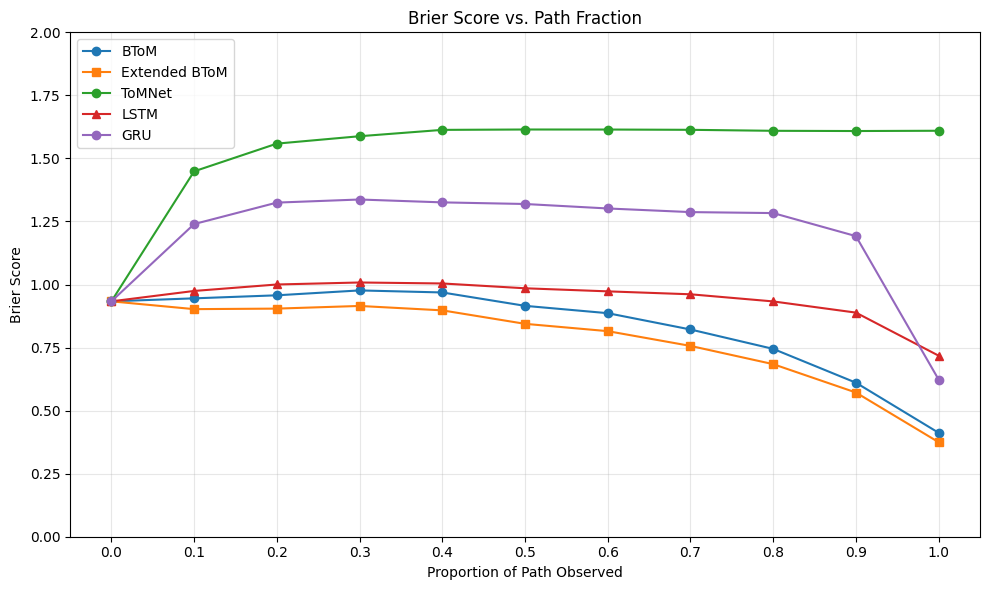

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
ext_arr  = np.array(ext_scores)
tomnet_arr = np.array(tomnet_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
plt.plot(props, mean_tomnet, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-^', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 2)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


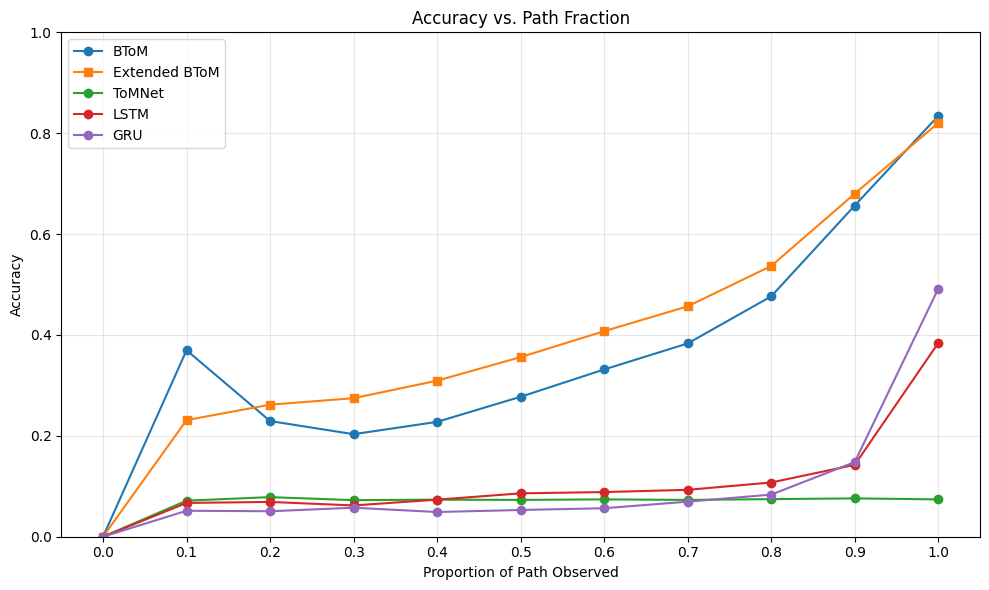

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(btom_acc)  # shape (N, 11)
ext_arr  = np.array(ext_acc)
tom_arr = np.array(tomnet_acc)
lstm_arr = np.array(lstm_acc)
gru_arr = np.array(gru_acc)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
mean_tom  = tom_arr.mean(axis=0)
mean_lstm  = lstm_arr.mean(axis=0)
mean_gru  = gru_arr.mean(axis=0)


plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
plt.plot(props, mean_tom, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-o', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

1. Use geospatial coordinates instead of IDs for nodes
2. Consider an embedding for the nodes --  we are using an embedding for the nodes
3. Consider multi head loss
4. Consider other loss functions for the distribution
5. The character net has a strange input where the multiple past trajs are concatenated